In [114]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

In [17]:
# Cargar el CSV
archivo_csv = os.path.join('..', '..', 'data', 'fact_licitacion-2007_2023-full.csv')
df_csv = pd.read_csv(archivo_csv, encoding="ISO-8859-1", delimiter=",")

In [19]:
df = df_csv.copy()

In [21]:
# Convertir la fecha a tipo datetime
df['id_fecha'] = pd.to_datetime(df['id_fecha'], format='%Y%m%d')

# 1. Crear características de fecha
df['mes'] = df['id_fecha'].dt.month
df['año'] = df['id_fecha'].dt.year


In [93]:
nombre_columna_objetivo = 'monto_adjudicado_usd'
columnas_utilizadas = ['año', 'mes', 'id_producto', nombre_columna_objetivo]

In [94]:
df = df.query(nombre_columna_objetivo + ' >= 0')

In [83]:
def filtrar_por_desviacion_estandar(df, factor=1):
    # Calcular la media y la desviación estándar para cada id_producto
    grouped_stats = df.groupby('id_producto')['monto_adjudicado_usd'].agg(['mean', 'std', 'count']).reset_index()

    # Calcular los límites inferior y superior para cada id_producto
    grouped_stats['lower_limit'] = grouped_stats['mean'] - factor * grouped_stats['std']
    grouped_stats['upper_limit'] = grouped_stats['mean'] + factor * grouped_stats['std']

    # Fusionar los límites con el DataFrame original
    df_merged = pd.merge(df, grouped_stats[['id_producto', 'lower_limit', 'upper_limit', 'count']], on='id_producto')

    # quito los productos con pocos registros
    meses = ((2022 - 2007) * 12) / 2
    df_merged = df_merged.query('count > ' + str(meses))

    # Filtrar los registros que están dentro del rango definido por los límites
    df_filtered = df_merged[(df_merged['monto_adjudicado_usd'] >= df_merged['lower_limit']) & 
                            (df_merged['monto_adjudicado_usd'] <= df_merged['upper_limit'])]

    return df_filtered

In [95]:
df_filtrado  = filtrar_por_desviacion_estandar(df[columnas_utilizadas])

In [96]:
# Visualizar los registros eliminados (opcional)
df_eliminado = df[~df.index.isin(df_filtrado.index)]

In [97]:
print(df.shape)
print(df_filtrado.shape)
print(df_eliminado.shape)

(12126438, 14)
(11681065, 7)
(445391, 14)


{'whiskers': [<matplotlib.lines.Line2D at 0x28c2d167d90>,
 'caps': [<matplotlib.lines.Line2D at 0x28c2d160310>,
 'boxes': [<matplotlib.lines.Line2D at 0x28c2d167af0>],
 'medians': [<matplotlib.lines.Line2D at 0x28c2d160850>],
 'fliers': [<matplotlib.lines.Line2D at 0x28c2d160af0>],
 'means': []}

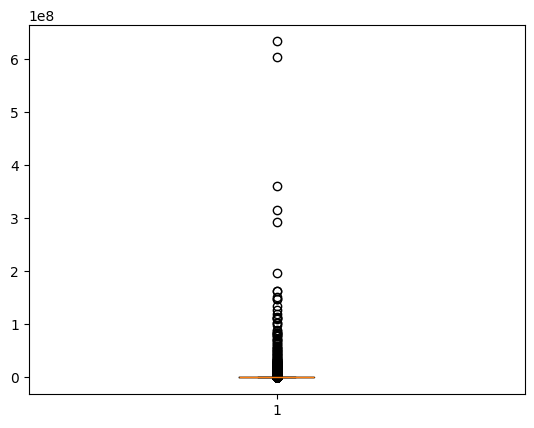

In [98]:
plt.boxplot(df_filtrado[nombre_columna_objetivo])

In [99]:
# Calcula el primer y tercer cuartil (Q1 y Q3) de la columna 'cantidad_adjudicada'
Q1 = df_filtrado[nombre_columna_objetivo].quantile(0.25)
Q3 = df_filtrado[nombre_columna_objetivo].quantile(0.75)

# Calcula el rango intercuartil (IQR)
IQR = Q3 - Q1

# Define un factor multiplicativo para ajustar el umbral (por ejemplo, 1.5 veces el IQR)
factor_umbral = 1.5

# Calcula el valor umbral
umbral = Q3 + factor_umbral * IQR


# Crea una nueva columna llamada 'segmento' en función del valor umbral
df_filtrado['segmento'] = [1 if x < umbral else 2 for x in df_filtrado[nombre_columna_objetivo]]

In [100]:
df_segm_1 = df_filtrado[df_filtrado['segmento'] == 1]
df_segm_2 = df_filtrado[df_filtrado['segmento'] == 2]
print([df_segm_1.shape,df_segm_2.shape])

[(9945088, 8), (1735977, 8)]


In [101]:
df_segm_1

,año,mes,id_producto,monto_adjudicado_usd,lower_limit,upper_limit,count,segmento
0,2007,1,51101720,181.310244,-5.843810e+03,7.359230e+03,2407,1
1,2007,1,51101720,49.952822,-5.843810e+03,7.359230e+03,2407,1
2,2007,1,51101720,46.252613,-5.843810e+03,7.359230e+03,2407,1
3,2007,2,51101720,27.882969,-5.843810e+03,7.359230e+03,2407,1
4,2007,2,51101720,50.897483,-5.843810e+03,7.359230e+03,2407,1
...,...,...,...,...,...,...,...,...
12124043,2022,1,101101001,0.001216,-6.855663e+06,1.121040e+07,2541,1
12124186,2022,3,101101001,0.001251,-6.855663e+06,1.121040e+07,2541,1
12124220,2022,3,101101001,0.001251,-6.855663e+06,1.121040e+07,2541,1
12124255,2022,3,101101001,0.001251,-6.855663e+06,1.121040e+07,2541,1


In [102]:
df_filtrado_segm_1  = filtrar_por_desviacion_estandar(df_segm_1[columnas_utilizadas])
df_filtrado_segm_1.shape

(8464246, 7)

{'whiskers': [<matplotlib.lines.Line2D at 0x28c2d1bd520>,
 'caps': [<matplotlib.lines.Line2D at 0x28c2d1bda60>,
 'boxes': [<matplotlib.lines.Line2D at 0x28c2d1bd280>],
 'medians': [<matplotlib.lines.Line2D at 0x28c2d1bdfa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x28c2d1c8280>],
 'means': []}

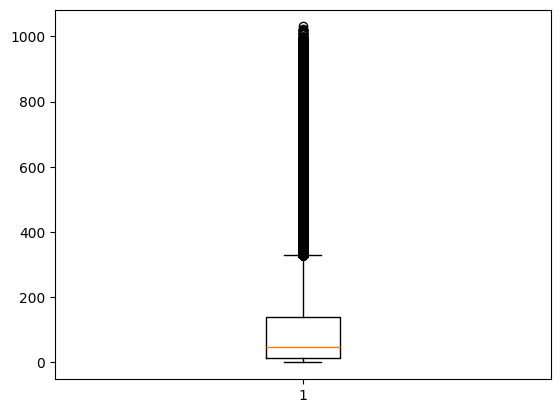

In [103]:
plt.boxplot(df_filtrado_segm_1[nombre_columna_objetivo])

In [107]:
# Dividir el conjunto de datos en características (X) y objetivo (y)
X = df_filtrado_segm_1[['año', 'mes', 'id_producto']]
y = df_filtrado_segm_1[nombre_columna_objetivo]

In [108]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f'Tamaño set de entrenamientos: X: {X_train.shape} y: {y_train.shape}')
print(f'Tamaño set de validacion: X: {X_valid.shape} y: {y_valid.shape}')
print(f'Tamaño set de prueba: X: {X_test.shape} y: {y_test.shape}')


Tamaño set de entrenamientos: X: (6771396, 3) y: (6771396,)
Tamaño set de validacion: X: (846425, 3) y: (846425,)
Tamaño set de prueba: X: (846425, 3) y: (846425,)


In [109]:
# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [110]:
df_train_scaled = pd.DataFrame(X_train_scaled, columns=[X_train.columns])
df_train_scaled.head()

,año,mes,id_producto
0,-0.790174,1.263573,-0.781741
1,-1.561330,0.096380,-0.270205
2,-0.019018,-1.362612,-1.887699
3,2.294449,-1.654411,0.053213
4,0.495085,-0.487217,-1.887699


In [113]:
np.random.seed(461)

# Construir el modelo de red neuronal con Keras
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Capa de salida, ya que es un problema de regresión
])

In [115]:
learning_rate = 0.002
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=["mae"])  # Cambiar la métrica a 'mae'

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                256       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# Compilar el modelo
# model.compile(optimizer='adam', loss='mean_squared_error')

In [118]:
# Entrenar el modelo
# model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)
score = model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_data=(X_valid_scaled, y_valid), verbose=1, shuffle=True)


Epoch 1/5
211607/211607 [==============================] - 154s 727us/step - loss: 81.0697 - mae: 81.0697 - val_loss: 80.6278 - val_mae: 80.6278
Epoch 2/5
211607/211607 [==============================] - 191s 904us/step - loss: 80.8036 - mae: 80.8036 - val_loss: 80.9222 - val_mae: 80.9222
Epoch 3/5
211607/211607 [==============================] - 151s 715us/step - loss: 80.8177 - mae: 80.8177 - val_loss: 80.4571 - val_mae: 80.4571
Epoch 4/5
211607/211607 [==============================] - 141s 665us/step - loss: 80.6112 - mae: 80.6112 - val_loss: 80.3341 - val_mae: 80.3341
Epoch 5/5
211607/211607 [==============================] - 140s 661us/step - loss: 80.4876 - mae: 80.4876 - val_loss: 80.4062 - val_mae: 80.4062


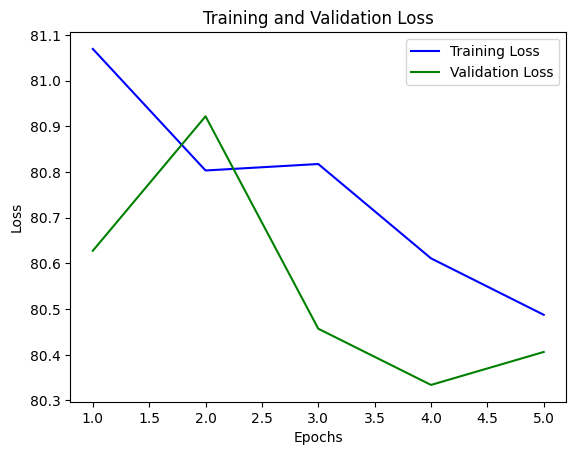

In [121]:
# Extraer la pérdida y la validación de la pérdida del historial
loss = score.history['loss']
val_loss = score.history['val_loss']

# Crear un gráfico de línea para visualizar la pérdida durante el entrenamiento
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()